In [3]:
import os 
import numpy as np
import healpy as hp
import mtneedlet as nl
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import broom
import matplotlib.pyplot as plt
from types import SimpleNamespace

from broom import (
    Configs,
    get_params,
    component_separation,_get_full_simulations, estimate_residuals, _combine_products)
from broom._needlets import _get_needlet_windows_
from broom.clusters import get_and_save_real_tracers_B
from IPython.display import Markdown

# root_path = os.path.dirname(os.path.abspath(broom.__file__))
root_path = os.path.dirname(os.path.dirname(os.path.abspath(broom.__file__)))
root_path

'/home/alecarones/Post-Doc/develop_code_nilcs'

## 🔧 Configuration Parameters

All **configuration parameters** are described in more detail in  
📄 [`configs/config_demo.yaml`](../tree/main/broom/configs/config_demo.yaml)  
within the **`broom`** package.


You can define **configuration parameters** in two ways:
- 📄 Using a `.yaml` **configuration file**


In [4]:
config_path = root_path + "/configs/config_satellite.yaml"

config: Configs = get_params(config_path=config_path)
print("Loaded configuration from\n", config_path)

Loaded configuration from
 /home/alecarones/Post-Doc/develop_code_nilcs/configs/config_satellite.yaml


- 💻 Directly within your Python script
(in this example they will match those of config_satellite.yaml as much as possible)

In [5]:
# Here you initialize all the main parameters.
# Some of them will be used for component separation runs, e.g. lmax, nside
config_values = {
    # Minimum multipole considered in the analysis (simulations generation, compsep, power spectrum computation)
    'lmin': 2, 
    # HEALPix resolution (used in simulations generation, compsep outputs)
    'nside': 64, 
    # If you use your own simulations, you can set this to HEALPix resolution of your simulations
    # This will be used to correct for input pixel window function (eventually) and 
    # made mask_observations compatible (see below).
    # Default: nside
    'nside_in': 64,
    # Maximum multipole considered in the analysis (simulations generation, compsep, power spectrum computation)
    # Default: 2*nside
    'lmax': 150, 
    # type of data to be returned by simulation generation or provided to component separation
    # It can be "maps" or "alms", 
    'data_type': "alms", 
    # Verbosity 
    'verbose': True,  
}

# Parameters for generation of simulations.
# Some information in experiment dictionary is used also in component separation.
config_sims_values = {
    # Pysm models of foreground components to be considered in the analysis
    'foreground_models': ["d1","s1"], 
    # Full path (including filename) of the yaml file where the instrument configuration is stored.
    # If not specified, it will set to 'utils/experiments.yaml' in broom package
    'experiments_file': root_path + "/utils/experiments.yaml",
    # name of the experiment to be considered, it should match dictionary name in 'experiments_file' yaml file.
    'experiment': "LiteBIRD_PTEP", 
     # Assumed units (for simulations generation and used in compsep for SEDs)
    # All methodologies reconstructing the CMB signal will return outputs in uk_CMB units.
    # All methodologies reconstructing foreground emission will return outputs in same units of inputs
    'units': "uK_CMB",
    # Adopted coordinate system, default: Galactic ("G"). Other options: 'E' (ecliptic) or 'C' (equatorial).
    # This should match the coordinates assumed for hits or depth maps, if provided.
    'coordinates': "G", 
}

# Parameters for the generation of input components for the simulations.
# All these parameters are necessary only if you intend to generate/save/load simulations through broom package
config_inputs_values = {
    # If True, input foregrounds are generated, otherwise they are read from the path specified in 'fgds_path'
    'generate_input_foregrounds': True, 
    # If True, single foreground components are returned, otherwise only the total foregrounds
    # Default: False.
    'return_fgd_components': False,
    # If True, foreground maps are integrated over the bandpass. Default: False.
    # See below and 'config_demo.yaml' for details on bandpass definition.
    'bandpass_integrate': False,
    # If True, input noise is generated, otherwise it is read from the path specified in 'noise_path'
    'generate_input_noise': True, #
    # If not None, it is used as seed for the noise generation. Default: None.
    'seed_noise': None,
    # If True, input CMB is generated, otherwise it is read from the path specified in 'cmb_path'
    'generate_input_cmb': True, #
    # If not None, it is used as seed for the CMB generation. Default: None.
    'seed_cmb': None,
    # Path (including filename) of the fits file with theoretical power spectrum for generating the CMB.
    # If not provided, it will use the one stored in the utils folder of the broom package
    # Units must be uK_CMB^2.
    'cls_cmb_path': None,
    # If True, the loaded cls from 'cls_cmb_path' are assumed to be in new ordering. Default: True.
    'cls_cmb_new_ordered': True,
    # If True, input data are generated coadding single components generated or loaded  
    # otherwise they are read from the path specified in 'data_path'
    'generate_input_data': True, #True #
    # If True, simulated components, if generated, are saved in paths provided below
    'save_inputs': False, # 
    # If True, pixel window function is applied to the input maps/alms
    # and input data provided to component separation are corrected for it (assuming the 'nside_in' parameter)
    'pixel_window_in': True,
    # Paths where inputs are saved/loaded from.
    'data_path': "/inputs/LiteBIRD_PTEP/total/total_alms_ns64",
    'fgds_path': "/inputs/LiteBIRD_PTEP/foregrounds/d1s1/foregrounds_alms_ns64",
    'cmb_path': "/inputs/LiteBIRD_PTEP/cmb/cmb_alms_ns64",
    'noise_path': "/inputs/LiteBIRD_PTEP/noise/noise_alms_ns64",
}

config_values.update(config_sims_values)
config_values.update(config_inputs_values)

config = Configs(config=config_values)


In [6]:
## Let's simulate the input data for the 'LiteBIRD_PTEP' experiment configuration

# data will be a SimpleNamespace with attributes:
#   - total: the total coadded signal (the only one really needed to run compsep in most cases)
#   - fgds: Multifrequency foreground signal
#   - noise: Multifrequency noise
#   - cmb: CMB

# If data_type is "maps", the data will be in the form of maps, otherwise it will be in the form of alms.

# If any among 'generate_input_foregrounds', 'generate_input_noise', and 'generate_input_cmb' is set to True, 
# the corresponding component is generated.
# Otherwise, it is loaded from the paths specified in the config. These files must be .npy files containing 
# the corresponding component at all observed frequencies.. shape (n_channels, 3, n_alms/n_pixels).
data = _get_full_simulations(config, nsim = 0)

# Of course, your own simulations can be used instead and stored in data SimpleNamespace.
# If, for example, your coadded and noise data are stored in 'my_data' and 'my_noise' variables, respectively, 
# as np.array files with (n_channels, 3, n_alms/n_pixels) shape
# you can create the data namespace like this:
# data = SimpleNamespace(total=my_data, noise=my_noise)

Generating foreground maps of d1s1 model


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating CMB simulation 00000
Generating noise simulation 00000
Generating coadded signal for simulation 00000


In [6]:
## We paste here a general scheme of an experiment dictionary which should be included in experiment_file
## This dictionary will be used both in simulations generation and component separation steps

instrument = {
    # List of central frequencies observed by the experiment
    'frequency': [40.0, 50.0, 60.0, 68.0, 68.0, 78.0, 78.0, 89.0, 89.0, 100.0, 100.0, 119.0, 119.0, 
                  140.0, 140.0, 166.0, 195.0, 195.0, 235.0, 280.0, 337.0, 402.0],
    # white noise map depths in intensity data (units: muK_arcmin).
    # If not provided, they will be assumed to be depth_P / sqrt(2)
    'depth_I': [37.42, 33.46, 21.31, 19.91, 31.77, 15.55, 19.13, 12.28, 28.77, 10.34, 8.48, 7.69, 5.70,
                7.25,  6.38, 5.57, 7.05, 10.50, 10.79, 13.80, 21.95, 47.45],
    # white noise map depths in polarization (units: muK_arcmin).
    # If not provided, they will be assumed to be depth_I * sqrt(2)
    # If both depth_I and depth_P are not provided, an error will be raised unless path_depth_maps is provided (see below)
    'depth_P': [37.42, 33.46, 21.31, 19.91, 31.77, 15.55, 19.13, 12.28, 28.77, 10.34, 8.48, 7.69, 5.70, 
                7.25, 6.38, 5.57, 7.05, 10.50, 10.79, 13.80, 21.95, 47.45],
    # FWHM of Gaussian beams associated to angular resolution of each channel
    # Used if "beams" is "gaussian"
    'fwhm': [70.5, 58.5, 51.1, 41.6, 47.1, 36.9, 43.8, 33.0, 41.5, 30.2, 37.8, 26.3, 33.6, 23.7, 30.8, 
             28.9, 28.0, 28.6, 24.7, 22.5, 20.9, 17.9],
    # List of tag for the different frequency channels.
    # If not provided, the code will generate an automated list.
    'channels_tags': [],
    # Relative bandwidth wrt the central frequency for each channel 
    # Used if config.bandpass_integrate is True and path_bandpasses is not provided
    # They refer to top-hat bandpasses in intensity units.
    'bandwidth':  [0.3, 0.3, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.3, 0.3, 0.3, 0.3,  
                   0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.23],
    # Path to bandpasses if different shapes from top-hat need to be considered.
    # Bandpasses will be loaded from {path_bandpasses} + '_{frequency_tag}.npy' files.
    # Provided bandpasses are assumed to be in intensity units.
    # Each file should include a 2D array with frequency (GHz) and frequency response.
    'path_bandpasses': "",
    # Nature of input beams. 
    # Used to smooth simulations and to bring maps to a common resolution before compsep if 'bring_to_common_resolution' is True.
    # Default: "gaussian".
    'beams': "gaussian", # "gaussian", "file_l" (symmetric but not gaussian beams), "file_lm" (asymmetric beams)
    # If "beams" is "file_l" or "file_lm", the beams are loaded from {path_beams} + '_{frequency_tag}.fits' file.
    # They should be arrays with shape (:,3)
    'path_beams': "",
    # If provided, the code will generate 1/f noise with spectrum according to  provided ell_knee and alpha_knee values.
    # List of float numbers with length equal to the number of channels.
    # Both must be provided.
    'ell_knee': [],
    'alpha_knee': [],
    # Full path to depths maps.
    # Maps are loaded from {path_depth_maps} + '_{frequency_tag}.fits' files.
    # They could be either 2 (I and P) fields per file or a single field (P is assumed and I scaled accordingly).
    # If provided, depth_I and depth_P will be ignored.
    'path_depth_maps': "",
    # Full path to hits maps, it can either:
    #   - be a single filename (ending with '.fits') and a single hits map will be assumed for all frequencies
    #   - it can link to different {path_hits_maps} + '_{frequency_tag}.fits' files.
    # If path_depth_maps is provided, this will be ignored.
    'path_hits_maps': "",}

# Note that both path_depth_maps and path_hits_maps are assumed to refer to the coordinate system provided
# in 'coordinates' keyword

## Inspection of inputs 

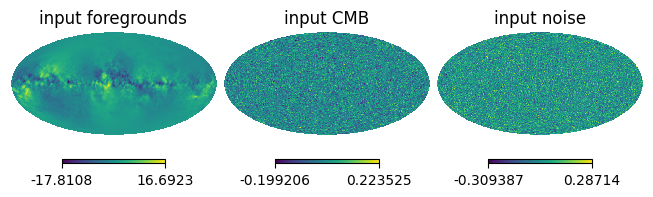

In [7]:
# Let's inspect e.g. B-mode input at a frequency channel

freq_idx = 12
field = 2

# data_type is "alms"
fgds = hp.alm2map(data.fgds[freq_idx,field],config.nside,lmax=config.lmax)
noise = hp.alm2map(data.noise[freq_idx,field],config.nside,lmax=config.lmax)
cmb = hp.alm2map(data.cmb[freq_idx,field],config.nside,lmax=config.lmax)

plt.figure()
hp.mollview(fgds, title="input foregrounds", sub=(1,3,1))
hp.mollview(cmb, title="input CMB", sub=(1,3,2))
hp.mollview(noise, title="input noise", sub=(1,3,3))

# 


# Component separation

In [7]:
# Common parameters for component separation runs.
config_common_cs = {
    # Requested resolution of outputs from compsep (in arcmin)
    'fwhm_out': 70.5, 
    # If True, input data are brought to 'fwhm_out' resolution. 
    # Adopted input beams depend on the experiment configuration. See above and 'config_demo.yaml' for details.
    'bring_to_common_resolution': True, 
    # If True, pixel window function is applied to the outputs from compsep according to nside parameter.
    'pixel_window_out': True,
    # Full path to the mask fits file which refers to the observed region.
    # It is used to compute alms from maps if data_type is 'maps'
    # Any unobserved region should be set to zero in this mask.
    # It can be an apodized mask to perform leakage correction with NaMaster.
    # If None, an array of ones is assumed (full sky observations).
    'mask_observations': None,
    # If provided, full path to mask fits file which is used to exclude and/or weight pixels in covariance computation.
    # In this mask you should set to zero the regions you want to exclude in component separation (but not excluded from observations)
    # If not provided, but mask_observations is, it will be equal to mask_observations
    'mask_covariance': None,
    # If provided, polarization maps will be corrected for EB-leakage before running component separation. 
    # See 'config_demo.yaml' and tutorial_groundbased.ipynb for details.
    'leakage_correction': None,
    # If True, the outputs are saved in the path specified in 'path_outputs'
    'save_compsep_products': True, 
    # If True, outputs will be returned by component separation functions.
    'return_compsep_products': True, #
    # Root path where outputs from compsep are saved if save_compsep_products is True. 
    # Specific subfolders are automatically generated for each compsep method.
    # The code will generate the full path.
    'path_outputs': "outputs/LiteBIRD_PTEP/d1s1",
    # Input fields associated to data provided to compsep.
    # Generally "TEB" for alms and "TQU" for maps, but can be different depending on your inputs.
    'field_in': "TEB", 
    # Output fields to be processed and returned (and/or saved) by compsep run. It can be whatever compatible with field_in.
    # Even if inputs are TEB, you can of course reconstruct TQU maps.
    # It can also be 'QU_E' or 'QU_B': the component separation will be done on E or B and then converted back to QU
    # It can be changed for each component separation run.
    'field_out': "B", # In this tutorial let's focus on B-modes
}

config_values.update(config_common_cs)
config = Configs(config=config_values)


## Running standard ILC in pixel space

In [9]:
# ILC in pixel domain

config_run = {
    'compsep': [{
    # Method to be applied
    'method': "ilc",
    # Domain in which the method is applied
    'domain': "pixel",
    # Amount of residual ILC bias. It is used to set the size of the domains where covariance is computed. 
    # If 0. (default), covariance is computed as the average over the full sky/patch.
    'ilc_bias': 0.001,
    # If different from 0. it will debias the covariance matrix by a factor cov_noise_debias * noise_covariance.
    # Default = 0.
    'cov_noise_debias': 0.
}]}

config_values.update(config_run)
config = Configs(config=config_values)
outputs_ilc = component_separation(config, data, nsim = 0)

Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running ilc in pixel domain for simulation 00000.


/home/alecarones/anaconda3/envs/test_install/lib/python3.10/site-packages/broom/_inputs.py:450: RuntimeWarning: divide by zero encountered in divide
  pixwin_inv = 1. / np.array(hp.pixwin(config.nside_in, pol=True, lmax=config.lmax))
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [12]:
print(f'Attributes of "outputs_ilc" are {", ".join(vars(outputs_ilc).keys())}')

# Shape corresponds to (n_runs, n_pixels) with n_runs number of compsep runs
print(f'Shape of each attribute is {np.array(outputs_ilc.total).shape}')

Attributes of "outputs_ilc" are cmb, noise, total, fgds
Shape of each attribute is (1, 49152)


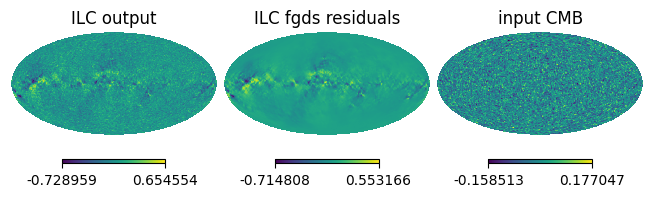

In [13]:
plt.figure()
hp.mollview(outputs_ilc.total[0], title="ILC output", sub=(1,3,1))
hp.mollview(outputs_ilc.fgds[0], title="ILC fgds residuals", sub=(1,3,2))
hp.mollview(outputs_ilc.cmb[0], title="input CMB", sub=(1,3,3))


## Needlet ILC

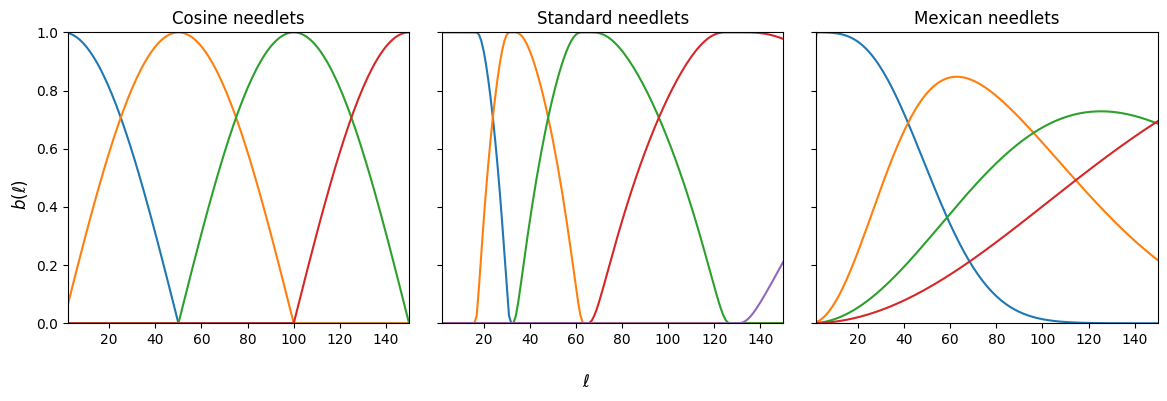

In [14]:
# Let's start by playing with needlets. 
# Three type of needlet wavelets are supported at the moment: "mexican", "standard" and "cosine"

ells = np.arange(config.lmax+1)

# Cosine needlets
needlet_config = {}
needlet_config["needlet_windows"] = "cosine"
needlet_config["ell_peaks"] = [0,50,100,150] # Sets the peaks of your cosine needlets
bl_cos = _get_needlet_windows_(needlet_config, config.lmax)

# Standard needlets
needlet_config = {}
needlet_config["needlet_windows"] = "standard"
needlet_config["width"] = 2.
#  Here it will merge all needlets between a needlet scale and the other included in the list
needlet_config["merging_needlets"] = [0, 5] # merging needlet between j=0 and j=4
bl_stand = _get_needlet_windows_(needlet_config, config.lmax)

# Mexican needlets
needlet_config = {}
needlet_config["needlet_windows"] = "mexican"
needlet_config["width"] = 1.3
#  Here it will merge all needlets between a needlet scale and the other included in the list
needlet_config["merging_needlets"] = [0, 14, 17, 19, 40] # 
bl_mex = _get_needlet_windows_(needlet_config, config.lmax)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax1.plot(ells,bl_cos.T)
ax2.plot(ells,bl_stand.T)
ax3.plot(ells,bl_mex.T)

ax1.set_xlim(2,config.lmax)
ax1.set_ylim(0.,1.)

ax1.set_title("Cosine needlets")
ax2.set_title("Standard needlets")
ax3.set_title("Mexican needlets")

fig.supxlabel(r"$\ell$")
fig.supylabel(r"$b(\ell)$")
plt.tight_layout()

In [15]:
# ILC in needlet domain (NILC)

config_run = {
    'compsep': [{
    'method': "ilc",
    'domain': "needlet", # needlet domain
    'ilc_bias': 0.001,
    # Needlet configuration
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    # If True, implement a ILC bias correction. 
    'reduce_ilc_bias': False,
    # If True, needlet bands are squared. Therefore needlet transformation is performed just once before component separation. 
    'b_squared': False,
    # If True, the HEALPix resolution of needlet maps is adapted to the sampled range of multipoles.    
    'adapt_nside': True,
    # If True, needlet bands are saved in the specific method path.  
    'save_needlets': True,
    # If True, the weights used to reconstruct the maps are saved in the path specified in path_outputs.
    'save_weights': True,
    # If different from 0. it will debias the covariance matrix by a factor cov_noise_debias * noise_covariance.
    # If float, it will be applied to all needlet bands.
    # If a list each element will be applied to corresponding needlet band.
    # Default = 0.
    'cov_noise_debias': [0.,0.,0.,0.]
}]}

config_values.update(config_run)
config = Configs(config=config_values)
outputs_nilc = component_separation(config, data, nsim = 0)

Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running ilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


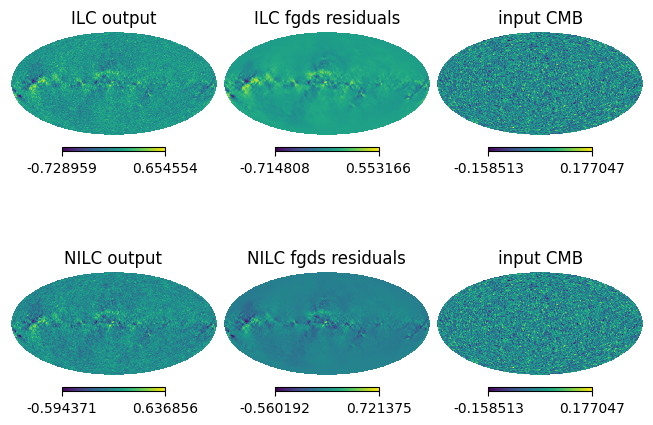

In [16]:
plt.figure()
hp.mollview(outputs_ilc.total[0], title="ILC output", sub=(2,3,1))
hp.mollview(outputs_ilc.fgds[0], title="ILC fgds residuals", sub=(2,3,2))
hp.mollview(outputs_ilc.cmb[0], title="input CMB", sub=(2,3,3))

hp.mollview(outputs_nilc.total[0], title="NILC output", sub=(2,3,4))
hp.mollview(outputs_nilc.fgds[0], title="NILC fgds residuals", sub=(2,3,5))
hp.mollview(outputs_nilc.cmb[0], title="input CMB", sub=(2,3,6))


In [17]:
# Outputs saved by component separation run can then also be loaded
from broom import _load_outputs

# This subpath will be added to the root path config.path_outputs
path_method = "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39"
path = os.path.join(config.path_outputs, path_method)
field_out = 'B'
# Output components you want to load
components = ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"]

loaded_outputs = _load_outputs(path, components, field_out, config.nside, config.lmax, config.fwhm_out, nsim=0)

# Shape: (n_comps, n_pixels)
print(f'Shape of loaded outputs is {loaded_outputs.shape}')


Shape of loaded outputs is (4, 49152)


## Constrained moments ILC (cMILC)

In [18]:
# Running cMILC with deprojection of all 0-th and 1-st order moments of dust and synchrotron
# Apply same compsep all needlet bands

config_run = {
    'compsep': [{
    'method': "cilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    # Needlet configuration
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    # Constraints for moments deprojection
    'constraints':
      [
       # List of moments to deproject. 
       # It can be a list of lists if different sets of moments needs to be deprojected at different needlet scales.
          {'moments': ["0d","0s","1bd","1bs","1Td"]},
       # dust spectral index, to be used for dust moments SEDs computation, default = 1.54
       # It can be a list, if different values need to be adopted for different needlet bands
          {'beta_d': 1.54}, # or [1.54, 1.5, 1.6, 1.55] for each needlet band
       # dust temperature (in Kelvin), to be used for dust moments SEDs computation, default = 20. 
       # It can be a list, if different values need to be adopted for different needlet bands
          {'T_d': 20.}, # or [20., 19., 21., 20.] for each needlet band
       # synch spectral index, to be used for synchrotron moments SEDs computation, default = -3.
       # It can be a list, if different values need to be adopted for different needlet bands
          {'beta_s': -3.}, # or [-3., -2.5, -3.5, -3.] for each needlet band
       # deprojection coefficients to be applied in each needlet band to each moment. default = 0. for each moment
       # It can be a list of lists, if different sets are needed for different needlet bands.
       # Weights will be constrained to set deprojection * input_moment the residue of that moment 
        {'deprojection': [0., 0., 0., 0., 0.]} # or [[0., 0., 0., 0., 0.], [0.1, 0.1, 0.1, 0.1, 0.1], ...]
      ],
# Other NILC secondary keywords can be used as save_needlets, save_weights, etc.
    'save_weights': True,
    'cov_noise_debias': [0.,0.,0.,0.],
}]}

config_values.update(config_run)
config = Configs(config=config_values)
outputs_cilc = component_separation(config, data, nsim = 0)

Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running cilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


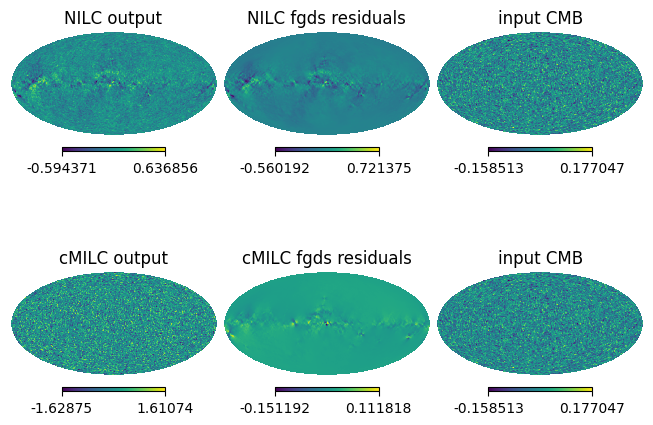

In [19]:
plt.figure()
hp.mollview(outputs_nilc.total[0], title="NILC output", sub=(2,3,1))
hp.mollview(outputs_nilc.fgds[0], title="NILC fgds residuals", sub=(2,3,2))
hp.mollview(outputs_nilc.cmb[0], title="input CMB", sub=(2,3,3))

hp.mollview(outputs_cilc.total[0], title="cMILC output", sub=(2,3,4))
hp.mollview(outputs_cilc.fgds[0], title="cMILC fgds residuals", sub=(2,3,5))
hp.mollview(outputs_cilc.cmb[0], title="input CMB", sub=(2,3,6))



In [20]:
# You can also apply moment deprojection on specific needlet bands set in special_nls keyword with c_ilc 

config_run = {
    'compsep': [{
    'method': "c_ilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    # Needlet configuration
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    # Constraints for moments deprojection
    'constraints':
      [
       {'moments': ["0d","0s","1bd","1bs","1Td"]},
       {'beta_d': 1.54}, 
          {'T_d': 20.}, 
          {'beta_s': -3.}, 
        {'deprojection': [0., 0., 0., 0., 0.]} 
      ],
    # Needlet scales where moment deprojection is applied
    'special_nls': [0,1]
# Other NILC secondary keywords can be used as save_needlets, save_weights, etc.
}]}

config_values.update(config_run)
config = Configs(config=config_values)
outputs_c_ilc = component_separation(config, data, nsim = 0)

Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running c_ilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


## Multi-Clustering ILC

In [21]:
# Application of MC-ILC with ideal clusters and 50 patches and clusters of equal area (CEA)
# MC-ILC can also be applied with Random partitions (RP) but it is a bit more computationally expensive
# See https://arxiv.org/abs/2212.04456 for details

config_run = {
    'compsep': [{
    'method': "mcilc",
    'domain': "needlet",
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    # Parameter which allows to reduce MC-ILC bias. 
    # Set it to True, here False just for speeding-up
    'reduce_mcilc_bias': False,
    # Type of sky partition (CEA or RP) and tracers (real or ideal)
    # With RP you are able to smooth border effects caused by partition
    'mc_type': "cea_ideal", # "cea_ideal", "rp_ideal", "cea_real", "rp_real"
    # indexes of the frequency channels to be used to construct the frequency ratio and build clusters
    'channels_tracers': [20,12], # 
    # Number of patches to use in the sky partition. By default 50.
    'n_patches': 50
# Other NILC secondary keywords can be used as save_needlets, save_weights, etc.
}]}

config_values.update(config_run)
config = Configs(config=config_values)
outputs_mcilc_id = component_separation(config, data, nsim = 0)

Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running mcilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


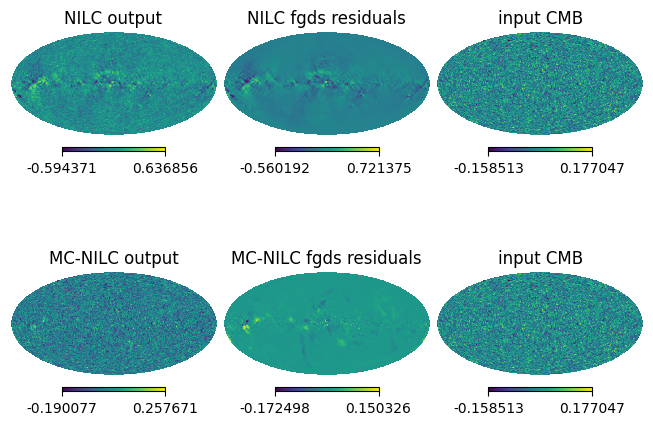

In [22]:
plt.figure()
hp.mollview(outputs_nilc.total[0], title="NILC output", sub=(2,3,1))
hp.mollview(outputs_nilc.fgds[0], title="NILC fgds residuals", sub=(2,3,2))
hp.mollview(outputs_nilc.cmb[0], title="input CMB", sub=(2,3,3))

hp.mollview(outputs_mcilc_id.total[0], title="MC-NILC output", sub=(2,3,4))
hp.mollview(outputs_mcilc_id.fgds[0], title="MC-NILC fgds residuals", sub=(2,3,5))
hp.mollview(outputs_mcilc_id.cmb[0], title="input CMB", sub=(2,3,6))


In [ ]:
# MC-ILC with realistic clusters

# Generation of the tracers for clusters construction
# You need to run this function (just once even if you run more simulations)
config_run = {
    'real_mc_tracers': [{
        # Indices of the frequency channels to be used for the MC-ILC clusters construction
        'channels_tracers': [20,12],
        # Full path where tracers will be saved.
        'path_tracers': "outputs/LiteBIRD_PTEP/d1s1/tracers",
        # Full path where generated tracers are svaed.
        # Every time a new realization of CMB and noise is generated
        # Default: inputs_mc_tracers/{config.experiment}
        'tracers_inputs_path': "mc_tracers_inputs/LiteBIRD_PTEP"
}]}
config_values.update(config_run)
config = Configs(config=config_values)

# Getting tracers
get_and_save_real_tracers_B(config, foregrounds = data.fgds)

# Running MC-ILC with sky partition from realistic tracers saved in the previous run 
# MC-ILC is applied only in needlet bands specified in 'special_nls' and ILC in the others (mc_ilc).

config_run = {
    'compsep': [{
    'method': "mc_ilc",
    'domain': "needlet",
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    'reduce_mcilc_bias': False,
    'mc_type': "cea_real", # "cea_ideal", "rp_ideal", "cea_real", "rp_real"
    'channels_tracers': [20,12], #
    'ilc_bias': 0.001,
    'n_patches': 50,
    # path where the MC-ILC tracers are stored. Used only if mc_type is "cea_real" or "rp_real".
    'path_tracers': "outputs/LiteBIRD_PTEP/d1s1/tracers", 
    'special_nls': [0]
# Other NILC secondary keywords can be used as save_needlets, save_weights, etc.
}]}

config_values.update(config_run)
config = Configs(config=config_values)
outputs_mcilc_re = component_separation(config, data, nsim = 0)


new_version
Generating input simulations for MC-ILC tracers



Generating the MC-ILC tracers for LiteBIRD_PTEP experiment and d1s1 foreground model
Simulation number not provided. If 'save_compsep_products' is set to True, the outputs will be saved without label on simulation number.
Pre-processing input alms for component separation.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation.
Running gilc in needlet domain.
No nuisance alms provided. Using input noise and CMB alms as nuisance.


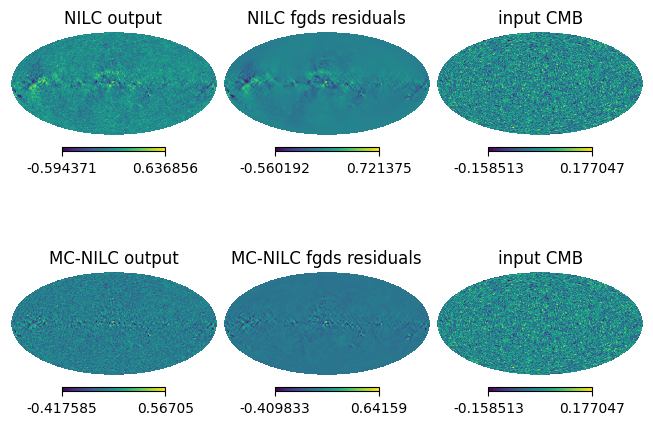

In [24]:
plt.figure()
hp.mollview(outputs_nilc.total[0], title="NILC output", sub=(2,3,1))
hp.mollview(outputs_nilc.fgds[0], title="NILC fgds residuals", sub=(2,3,2))
hp.mollview(outputs_nilc.cmb[0], title="input CMB", sub=(2,3,3))

hp.mollview(outputs_mcilc_re.total[0], title="MC-NILC output", sub=(2,3,4))
hp.mollview(outputs_mcilc_re.fgds[0], title="MC-NILC fgds residuals", sub=(2,3,5))
hp.mollview(outputs_mcilc_re.cmb[0], title="input CMB", sub=(2,3,6))


## Combination of products from different component separation runs

In [25]:
# If you run different methodologies on different fields 
# you can then recombine the products in a single file if you need it

# E-mode run
config_run = {
    'compsep': [ 
    {'method': "ilc", 'domain': "needlet",
    'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    'reduce_ilc_bias': False, 'b_squared': False,
    'adapt_nside': True, 'save_needlets': True, 'save_weights': True, 'cov_noise_debias': [0.,0.,0.,0.]}
    ]}

config_values.update(config_run)
config = Configs(config=config_values)
config.config["field_out"] = "E"
config.config["return_compsep_products"] = False
config._store_passed_settings()   # refresh all dependent attributes
component_separation(config, data, nsim = 0)

# B-mode run
config_run = {
    'compsep': [ 
    {'method': "mcilc",
    'domain': "needlet",
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    'reduce_mcilc_bias': False,
    'mc_type': "cea_ideal", 'channels_tracers': [20,12]}
]}
config_values.update(config_run)
config = Configs(config=config_values)
config.config["field_out"] = "B"
config._store_passed_settings()   # refresh all dependent attributes
component_separation(config, data, nsim = 0)

Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running ilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running mcilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [26]:
# Combination of the component separation outputs
# You need to set the 'combine_outputs' dictionary 

config_run = {
    'combine_outputs': [{
        # List of fields returned by the different component separation runs 
        'fields_in': ["E", "B"],
        # Fields to be saved from the combination of the products
        'fields_out': "QU", # In this case, it could have also been "EB"
        # Path where outputs of each component separation run are stored.
        # They will be added to the root path config.path_outputs
        'paths_fields_in': ["ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39",
                "mcilc_needlet/mexican_B1.3_j0j13_j14j16_j17j18_j19j39/cea_ideal_337.0GHz_119.0bGHz_50patches"],
        # Path where combined products will be stored if config.save_compsep_products is True.
        # It will be added to root path config.path_outputs for the full path
        'path_out': "Enilc_Bmcilc_ceaideal",
        # Components saved by both component separation runs which will be combined
        'components': ["output_total"]
}]}

config_values.update(config_run)
config = Configs(config=config_values)
config.config["return_compsep_products"] = True
config._store_passed_settings()   # refresh all dependent attributes

combined_outputs = _combine_products(config, nsim=0)

setting the output map dtype to [dtype('float64'), dtype('float64')]


## Component separation can also be applied on Polarization intensity:

- Polarization ILC (PILC)

- constained PILC (cPILC)

In [27]:
# The output can be both EB, QU, QU_E, QU_B


# Example of PILC in pixel domain
config_run = {
    'field_out': 'EB',
    'compsep': [{
    # Method to be applied
    'method': "pilc",
    # Domain in which the method is applied
    'domain': "pixel",
    # Amount of residual ILC bias. It is used to set the size of domain where covariance is computed. 
    # If 0., covariance is computed as the average over the full sky/patch.
    'ilc_bias': 0.001,
    'cov_noise_debias': 0.,
}]}

config_values.update(config_run)
config = Configs(config=config_values)
outputs_pilc = component_separation(config, data, nsim = 0)

# Example of PILC in needlet domain
config_run = {
    'compsep': [{
    'method': "pilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    'reduce_ilc_bias': False,
    'adapt_nside': False,
    'save_needlets': True,
    'save_weights': True,
    'cov_noise_debias': [0.,0.,0.,0.],
}]}
config_values.update(config_run)
config = Configs(config=config_values)
outputs_npilc = component_separation(config, data, nsim = 0)

# Example of cPILC

config_run = {
    'compsep': [{
    'method': "cpilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    'constraints':
      [
       {'moments': ["0d","0s","1bd","1bs","1Td"]},
       {'beta_d': 1.54}, # or [1.54, 1.5, 1.6, 1.55] for each needlet band
       {'T_d': 20.}, # or [20., 19., 21., 20.] for each needlet band
       {'beta_s': -3.}, # or [-3., -2.5, -3.5, -3.] for each needlet band
       {'deprojection': [0., 0., 0., 0., 0.]} # or [[0., 0., 0., 0., 0.], [0.1, 0.1, 0.1, 0.1, 0.1], ...]
      ],
# Other NILC secondary keywords can be used as save_needlets, save_weights, etc.
    'save_weights': True,
}]}
config_values.update(config_run)
config = Configs(config=config_values)
outputs_cpilc = component_separation(config, data, nsim = 0)


# Example of patrially constrained PILC

config_run = {
    'compsep': [{
    'method': "c_pilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    'constraints':
      [
       {'moments': ["0d","0s","1bd","1bs","1Td"]},
       {'beta_d': 1.54}, 
          {'T_d': 20.}, 
          {'beta_s': -3.}, 
        {'deprojection': [0., 0., 0., 0., 0.]} 
      ],
    # Needlet scales where moment deprojection is applied
    'special_nls': [0,1]
# Other NILC secondary keywords can be used as save_needlets, save_weights, etc.
}]}
config_values.update(config_run)
config = Configs(config=config_values)
outputs_c_pilc = component_separation(config, data, nsim = 0)


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running pilc in pixel domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running pilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running cpilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running c_pilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


In [28]:
# Outputs will be shaped as (n_cases, n_fields, n_pixels)
# where n_cases is number of compsep runs requested
outputs_pilc.total.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
plt.figure()
hp.mollview(outputs_pilc.total[0,1], title="PILC output", sub=(3,3,1))
hp.mollview(outputs_pilc.fgds[0,1], title="PILC fgds residuals", sub=(3,3,2))
hp.mollview(outputs_pilc.cmb[0,1], title="input CMB", sub=(3,3,3))

hp.mollview(outputs_npilc.total[0,1], title="NPILC output", sub=(3,3,4))
hp.mollview(outputs_npilc.fgds[0,1], title="NPILC fgds residuals", sub=(3,3,5))
hp.mollview(outputs_npilc.cmb[0,1], title="input CMB", sub=(3,3,6))

hp.mollview(outputs_cpilc.total[0,1], title="cPILC output", sub=(3,3,7))
hp.mollview(outputs_cpilc.fgds[0,1], title="cPILC fgds residuals", sub=(3,3,8))
hp.mollview(outputs_cpilc.cmb[0,1], title="input CMB", sub=(3,3,9))
